In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Git Repos

In [1]:
!git clone https://github.com/advimman/lama.git
!git clone https://github.com/lorenzo-stacchio/Stable-Diffusion-Inpaint.git

Cloning into 'lama'...
remote: Enumerating objects: 478, done.
remote: Counting objects: 100% (271/271), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 478 (delta 151), reused 110 (delta 110), pack-reused 207 (from 2)
Receiving objects: 100% (478/478), 8.84 MiB | 26.15 MiB/s, done.
Resolving deltas: 100% (192/192), done.
Cloning into 'Stable-Diffusion-Inpaint'...
remote: Enumerating objects: 1091, done.
remote: Total 1091 (delta 0), reused 0 (delta 0), pack-reused 1091 (from 1)
Receiving objects: 100% (1091/1091), 48.90 MiB | 38.60 MiB/s, done.
Resolving deltas: 100% (580/580), done.


# Downloading Data and model_compvis.ckpt For Stable Difussion

In [2]:
!wget -O models/ldm/inpainting_big/inpainting_big.zip https://ommer-lab.com/files/latent-diffusion/inpainting_big.zip

models/ldm/inpainting_big/inpainting_big.zip: No such file or directory


In [8]:
!mkdir -p /kaggle/working/models/ldm/inpainting_big

In [9]:
!wget -O models/ldm/inpainting_big/model_compvis.ckpt https://ommer-lab.com/files/latent-diffusion/inpainting_big.zip --no-check-certificate

--2025-04-27 12:24:21--  https://ommer-lab.com/files/latent-diffusion/inpainting_big.zip
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3311259854 (3.1G) [application/zip]
Saving to: ‘models/ldm/inpainting_big/model_compvis.ckpt’

models/ldm/inpainti 100%[===================>]   3.08G  30.3MB/s    in 1m 48s  

2025-04-27 12:26:10 (29.3 MB/s) - ‘models/ldm/inpainting_big/model_compvis.ckpt’ saved [3311259854/3311259854]



# Manual Script for Stable Difussion

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

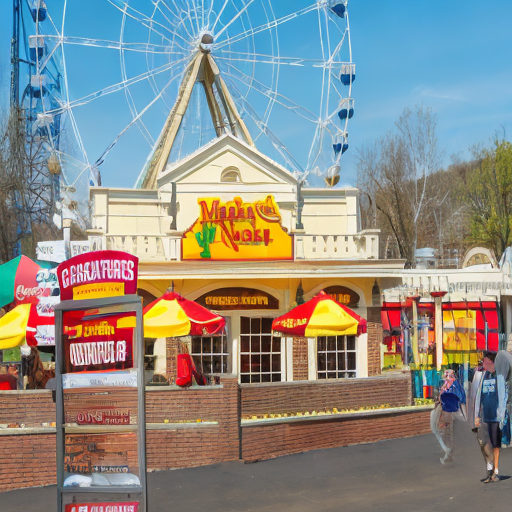

In [12]:
import torch
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline
from IPython.display import display

# Load the model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to("cuda")

pipe.enable_attention_slicing()

# Load your input image
init_image = Image.open("/kaggle/input/inputs/LaMa_test_images/000068.png").convert("RGB").resize((512, 512))

# Load your mask image
mask_image = Image.open("/kaggle/input/inputs/LaMa_test_images/000068_mask.png").convert("L").resize((512, 512))
mask_image = mask_image.point(lambda p: 255 if p > 127 else 0)  # Make sure mask is binary

# Inpaint the masked area
with torch.no_grad():
    result = pipe(
        prompt="",  # No prompt, just remove object
        image=init_image,
        mask_image=mask_image,
        strength=1,
        guidance_scale=5.0,
        num_inference_steps=30,
    ).images[0]

# Save and display the result
result.save("/kaggle/working/output.jpg")
display(result)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

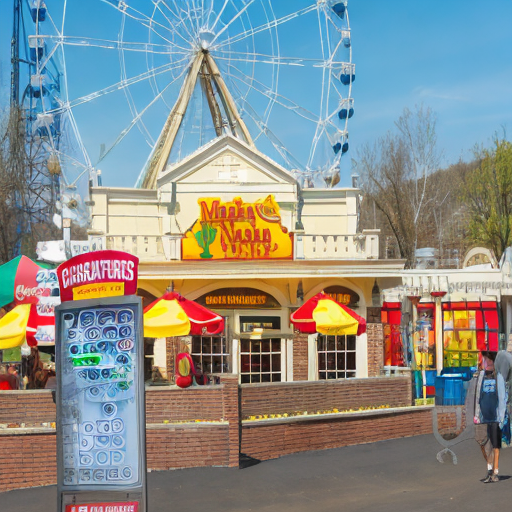

In [19]:
import torch
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline
from IPython.display import display

def inpaint_image(original_image_path, mask_image_path, output_path, prompt="", strength=1, guidance_scale=5.0, num_inference_steps=30):
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16,
    ).to("cuda")

    pipe.enable_attention_slicing()

    init_image = Image.open(original_image_path).convert("RGB").resize((512, 512))

    mask_image = Image.open(mask_image_path).convert("L").resize((512, 512))
    mask_image = mask_image.point(lambda p: 255 if p > 127 else 0)  

    with torch.no_grad():
        result = pipe(
            prompt=prompt,  
            image=init_image,
            mask_image=mask_image,
            strength=strength,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
        ).images[0]

    result.save(output_path)
    display(result)

inpaint_image(
    original_image_path="/kaggle/input/inputs/LaMa_test_images/000068.png",
    mask_image_path="/kaggle/input/inputs/LaMa_test_images/000068_mask.png",
    output_path="/kaggle/working/output.jpg",
    prompt="Fill the masked area with background pixels, seamlessly blending with the surrounding area for a realistic result"  
)


In [20]:
import os
import shutil
import subprocess
import matplotlib.pyplot as plt
from PIL import Image

def run_inpaint_inference(original_image_path, mask_image_path):
    # Prepare temp and results directories
    temp_input_dir = "/kaggle/working/temp_input"
    temp_output_dir = "/kaggle/working/temp_output"

    os.makedirs(temp_input_dir, exist_ok=True)
    os.makedirs(temp_output_dir, exist_ok=True)

    try:
        # Copy original and mask images to temp_input_dir
        shutil.copy(original_image_path, temp_input_dir)
        shutil.copy(mask_image_path, temp_input_dir)

        # Prepare the environment variables (optional)
        env = os.environ.copy()
        env["PYTHONPATH"] = "/kaggle/working/inpaint_project"  # adjust if needed

        # Run inpaint inference subprocess
        command = [
            "python", "/kaggle/working/Stable-Diffusion-Inpaint/inpaint_inference.py",
            "--indir", temp_input_dir,
            "--outdir", temp_output_dir,
            "--ckpt", "/kaggle/working/models/ldm/inpainting_big/model_compvis.ckpt",
            "--yaml_profile", "/kaggle/working/Stable-Diffusion-Inpaint/configs/latent-diffusion/inpainting_inference.yaml",
            "--device", "cuda:0",
            "--prefix", "test_example"
        ]

        print("Running inpaint inference...")
        result = subprocess.run(command, env=env, capture_output=True, text=True)

        if result.returncode != 0:
            print("Error running inpainting:")
            print(result.stderr)
            raise RuntimeError("Inpainting subprocess failed.")

        # Find the output image
        output_files = os.listdir(temp_output_dir)
        output_image_path = None
        for filename in output_files:
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                output_image_path = os.path.join(temp_output_dir, filename)
                break

        if output_image_path is None:
            raise FileNotFoundError(f"No output image found in {temp_output_dir}")

        # Load and display images
        original_image = Image.open(original_image_path)
        output_image = Image.open(output_image_path)

        fig, axes = plt.subplots(1, 2, figsize=(15, 7))

        axes[0].imshow(original_image)
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(output_image)
        axes[1].set_title("Inpainted Image (Output)")
        axes[1].axis('off')

        plt.show()

    except Exception as e:
        print(f"Error: {e}")

    finally:
        # Clean up
        if os.path.exists(temp_input_dir):
            shutil.rmtree(temp_input_dir)
        if os.path.exists(temp_output_dir):
            shutil.rmtree(temp_output_dir)
        print("Temporary folders cleaned up.")



In [21]:
run_inpaint_inference("/kaggle/input/inputs/LaMa_test_images/000068.png", 
                      "/kaggle/input/inputs/LaMa_test_images/000068_mask.png")


Running inpaint inference...
Error running inpainting:
/kaggle/working/Stable-Diffusion-Inpaint/inpaint_inference.py:103: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  device = torch.device(opt.device) if torch.cuda.is_available() and opt.device is not "cpu" else torch.device("cpu")
Traceback (most recent call last):
  File "/kaggle/working/Stable-Diffusion-Inpaint/inpaint_inference.py", line 8, in <module>
    from main_inpainting import instantiate_from_config
  File "/kaggle/working/Stable-Diffusion-Inpaint/main_inpainting.py", line 16, in <module>
    from pytorch_lightning.utilities.distributed import rank_zero_only
ModuleNotFoundError: No module named 'pytorch_lightning.utilities.distributed'

Error: Inpainting subprocess failed.
Temporary folders cleaned up.


In [22]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.

In [25]:
!cd Stable-Diffusion-Inpaint

Enter the path to the input image:  /kaggle/input/inputs/LaMa_test_images/000068.png
Enter the path to the mask image:  /kaggle/input/inputs/LaMa_test_images/000068_mask.png


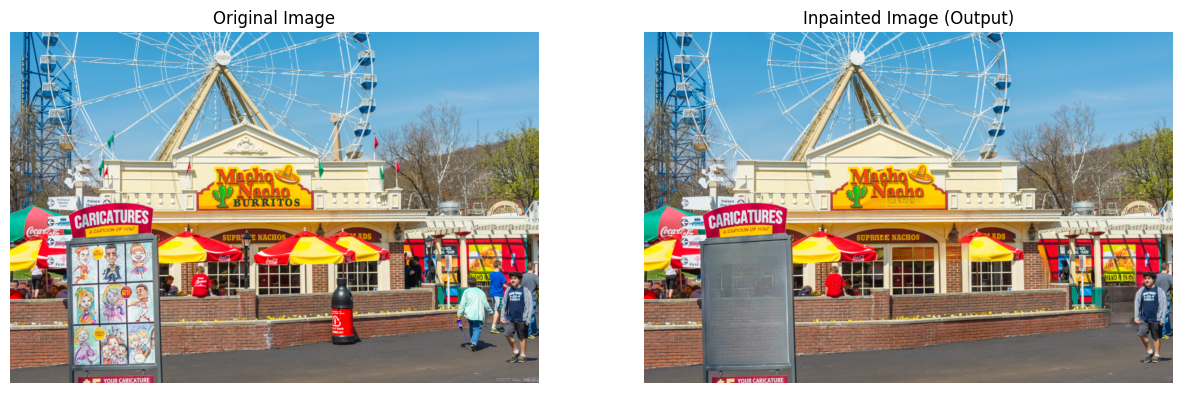

Temporary input and output folders have been cleaned up.


In [23]:
import os
import shutil
import subprocess
import sys
import matplotlib.pyplot as plt
from PIL import Image

# Step 1: User inputs
image_path = input("Enter the path to the input image: ").strip()
mask_path = input("Enter the path to the mask image: ").strip()

# Step 2: Prepare temp directory
temp_dir = "/kaggle/working/temp_input"
lama_results_dir = "/kaggle/working/lama_results"

os.makedirs(temp_dir, exist_ok=True)
os.makedirs(lama_results_dir, exist_ok=True)

# Step 3: Copy image and mask into temp_dir
shutil.copy(image_path, temp_dir)
shutil.copy(mask_path, temp_dir)

# Step 4: Set environment for subprocess
env = os.environ.copy()
env["PYTHONPATH"] = "/kaggle/working/lama"  

# Step 5: Run LaMa prediction silently
command = [
    "python", "bin/predict.py",
    "model.path=/kaggle/input/big-lama/big-lama",
    f"indir={temp_dir}",
    f"outdir={lama_results_dir}"
]

subprocess.run(command, env=env, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Step 6: Find output image
image_name = os.path.basename(image_path)
input_name, _ = os.path.splitext(image_name)

output_files = os.listdir(lama_results_dir)
output_image_path = None

for filename in output_files:
    if input_name in filename:
        output_image_path = os.path.join(lama_results_dir, filename)
        break

if output_image_path is None:
    raise FileNotFoundError(f"No output image matching {input_name} found!")

# Step 7: Load images
original_image = Image.open(image_path)
output_image = Image.open(output_image_path)

# Step 8: Display images
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(output_image)
axes[1].set_title("Inpainted Image (Output)")
axes[1].axis('off')

plt.show()

# Step 9: Clean up
shutil.rmtree(temp_dir)
shutil.rmtree(lama_results_dir)

print("Temporary input and output folders have been cleaned up.")


# Manual Script

In [16]:
import os
import shutil
import subprocess
import matplotlib.pyplot as plt
from PIL import Image

def run_lama_inpaint(original_image_path, mask_image_path):
    # Prepare temp and results directories
    base_temp_dir = "/kaggle/working/temp_input"
    lama_results_dir = "/kaggle/working/lama_results"

    os.makedirs(base_temp_dir, exist_ok=True)
    os.makedirs(lama_results_dir, exist_ok=True)

    try:
        # Copy original image and mask into the temp directory
        shutil.copy(original_image_path, base_temp_dir)
        shutil.copy(mask_image_path, base_temp_dir)

        # Set environment for subprocess
        env = os.environ.copy()
        env["PYTHONPATH"] = "/kaggle/working/lama"

        # Run LaMa prediction
        command = [
            "python", "bin/predict.py",
            "model.path=/kaggle/input/big-lama/big-lama",
            f"indir={base_temp_dir}",
            f"outdir={lama_results_dir}",
            "hydra.run.dir=/kaggle/working"
        ]

        print("Running LaMa inpainting...")
        result = subprocess.run(command, env=env, capture_output=True, text=True)

        if result.returncode != 0:
            print("Error running LaMa:")
            print(result.stderr)
            raise RuntimeError("LaMa subprocess failed.")

        # Wait a little to ensure output files are written
        output_files = os.listdir(lama_results_dir)
        output_image_path = None
        for filename in output_files:
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for valid output file
                output_image_path = os.path.join(lama_results_dir, filename)
                break

        if output_image_path is None:
            raise FileNotFoundError(f"No output image found in {lama_results_dir}")

        # Load original and output images
        original_image = Image.open(original_image_path)
        output_image = Image.open(output_image_path)

        # Display the images
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))

        axes[0].imshow(original_image)
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(output_image)
        axes[1].set_title("Inpainted Image (Output)")
        axes[1].axis('off')

        plt.show()

    except Exception as e:
        print(f"Error: {e}")

    finally:
        # Clean up temporary directories
        if os.path.exists(base_temp_dir):
            shutil.rmtree(base_temp_dir)
        if os.path.exists(lama_results_dir):
            shutil.rmtree(lama_results_dir)

        print("Temporary input and output folders have been cleaned up.")




In [15]:
cd /kaggle/working/lama

/kaggle/working/lama


Running LaMa inpainting...


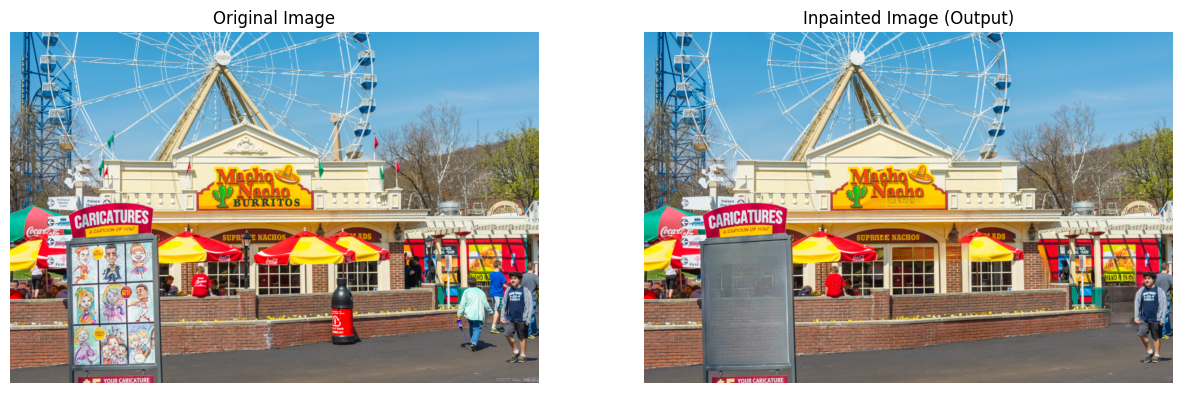

Temporary input and output folders have been cleaned up.


In [17]:
run_lama_inpaint(
    "/kaggle/input/inputs/LaMa_test_images/000068.png",
    "/kaggle/input/inputs/LaMa_test_images/000068_mask.png"
)

# Libraries installation

In [ ]:
!PYTHONPATH=. python bin/predict.py \
    model.path=/kaggle/input/big-lama/big-lama \
    indir=/kaggle/working/input_lama/images \
    outdir=/kaggle/working/lama_results

In [13]:
!pip install -q webdataset
!pip install -q hydra-core --upgrade
!pip install -q albumentations==0.5.2
!pip install ipywidgets gradio
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.9/index.html
!pip install git+https://github.com/facebookresearch/detectron2.git@main
!pip install ipywidgets gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 33.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 102.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.9/index.html
ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2
  Cloning https://github.com/f

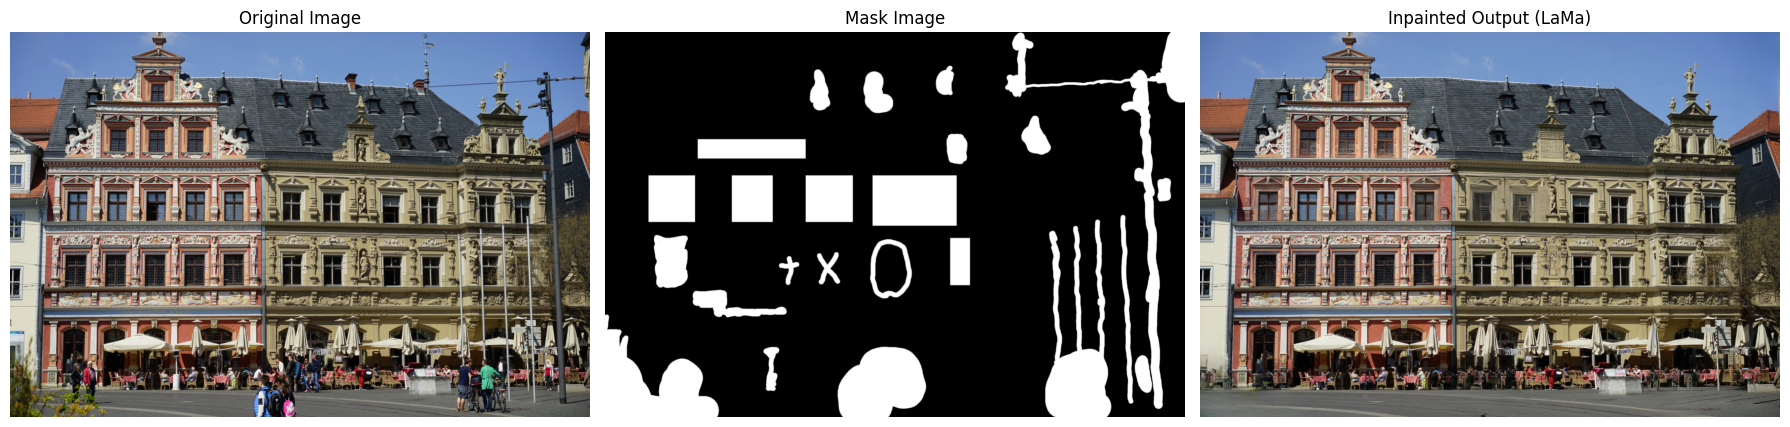

In [15]:
import matplotlib.pyplot as plt
import cv2

original_path = '/kaggle/input/inputs/LaMa_test_images/000814.png'
mask_path = '/kaggle/input/inputs/LaMa_test_images/000814_mask.png'
inpainted_path = '/kaggle/working/lama_results/000814_mask.png'

original = cv2.imread(original_path)
mask = cv2.imread(mask_path)
inpainted = cv2.imread(inpainted_path)

original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
inpainted = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.axis("off")
plt.title("Mask Image")

plt.subplot(1, 3, 3)
plt.imshow(inpainted)
plt.axis("off")
plt.title("Inpainted Output (LaMa)")

plt.tight_layout()
plt.show()


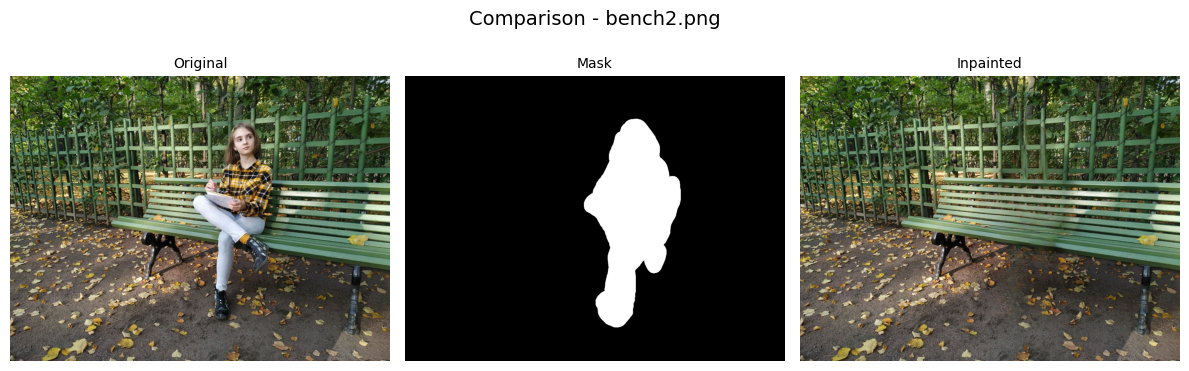

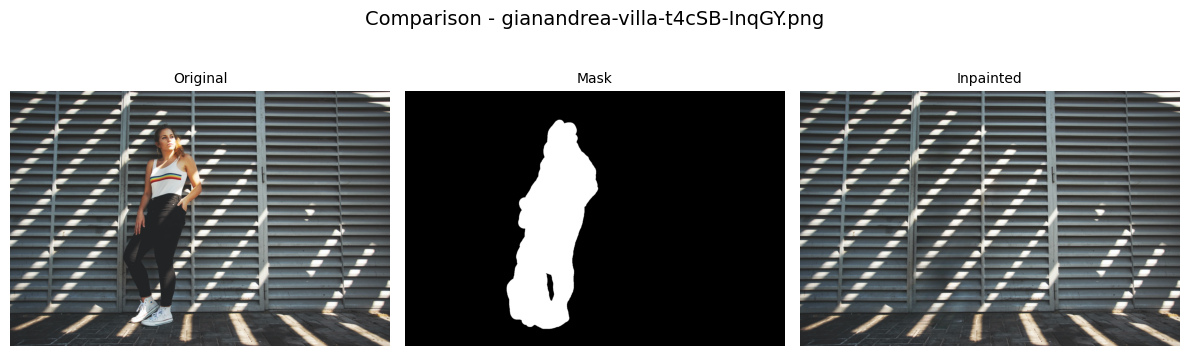

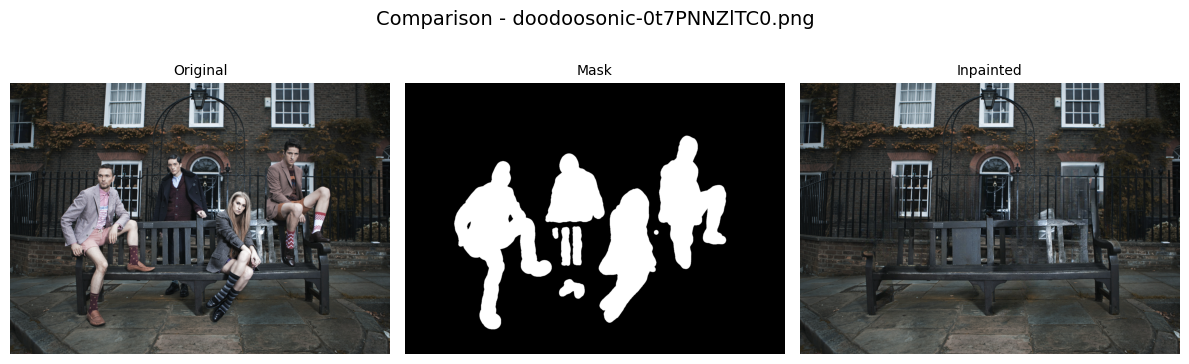

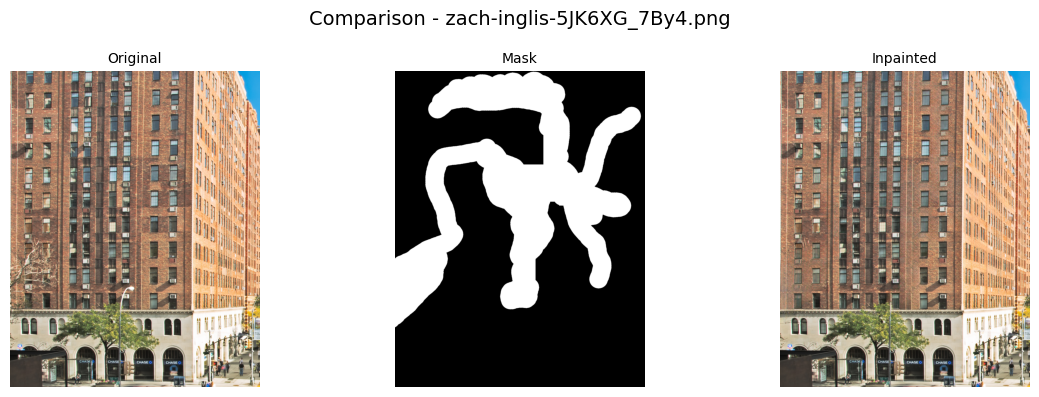

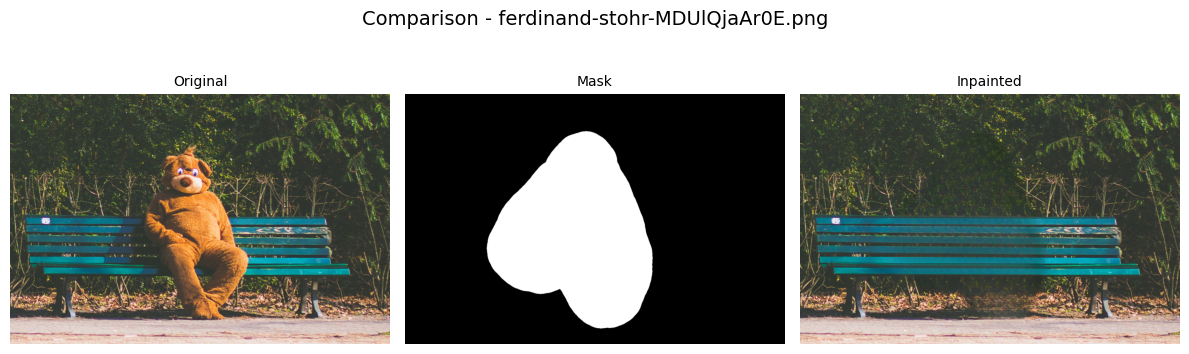

In [14]:
import os
import random
import matplotlib.pyplot as plt
import cv2


input_dir = '/kaggle/input/inputs/LaMa_test_images'
output_dir = '/kaggle/working/lama_results'


all_files = os.listdir(input_dir)
image_files = [f for f in all_files if f.endswith('.png') and '_mask' not in f]


sample_images = random.sample(image_files, min(5, len(image_files)))

for img_name in sample_images:
    base_name = img_name.replace('.png', '')
    

    original_path = os.path.join(input_dir, img_name)
    mask_path = os.path.join(input_dir, f"{base_name}_mask.png")
    inpainted_path = os.path.join(output_dir, f"{base_name}_mask.png")
    

    original = cv2.imread(original_path)
    mask = cv2.imread(mask_path)
    inpainted = cv2.imread(inpainted_path)


    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    inpainted = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)


    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Comparison - {img_name}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.axis("off")
    plt.title("Original", fontsize=10)

    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.axis("off")
    plt.title("Mask", fontsize=10)

    plt.subplot(1, 3, 3)
    plt.imshow(inpainted)
    plt.axis("off")
    plt.title("Inpainted", fontsize=10)

    plt.tight_layout()
    plt.show()


In [4]:
# Load LaMa model
from lama import LaMaInpainter  # or however you imported it earlier
lama_inpainter = LaMaInpainter(model_path='path_to_lama_model')

# Load Stable Diffusion Inpainting model
from diffusers import StableDiffusionInpaintPipeline
import torch

stable_diffusion_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to('cuda')


ImportError: cannot import name 'LaMaInpainter' from 'lama' (unknown location)